In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, average_precision_score, classification_report, confusion_matrix, roc_curve

import matplotlib.pyplot as plt
%config InlineBackend.figure_format='svg'
plt.rcParams.update({
    'text.usetex':False,
    'font.family':'monospace'
})  
import seaborn as sns

import optuna
from xgboost import XGBClassifier

Bootstrapping to find the confidence intervals for the AUROC score

In [2]:
def bootstrap_auc_ci(y_true, y_scores, n_bootstraps=2000, ci=0.95):
    rng = np.random.default_rng(42)
    aucs = []

    y_true = np.array(y_true)
    y_scores = np.array(y_scores)

    for _ in range(n_bootstraps):
        idx = rng.integers(0, len(y_true), len(y_true))
        if len(np.unique(y_true[idx])) < 2:
            continue
        aucs.append(roc_auc_score(y_true[idx], y_scores[idx]))

    lower = np.percentile(aucs, (1 - ci) / 2 * 100)
    upper = np.percentile(aucs, (1 + ci) / 2 * 100)
    return np.mean(aucs), lower, upper

## Loading the dataset, pre-processing, and analysing the data

In [3]:
cohort_data = pd.read_csv('../cohort_data_new.csv')
cohort_data

,icustay_id,anion_gap_mean,anion_gap_sd,anion_gap_min,anion_gap_max,bicarbonate_mean,bicarbonate_sd,bicarbonate_min,bicarbonate_max,calcium_total_mean,...,urea_nitrogen_min,urea_nitrogen_max,white_blood_cells_mean,white_blood_cells_sd,white_blood_cells_min,white_blood_cells_max,age,gender,icu_los_hours,target
0,200003,13.375000,3.583195,9.0,21.0,25.250000,3.105295,18.0,28.0,7.771429,...,10.0,21.0,26.471429,13.176711,13.2,43.9,48,M,141,0
1,200007,15.500000,2.121320,14.0,17.0,23.000000,1.414214,22.0,24.0,8.900000,...,8.0,10.0,10.300000,1.272792,9.4,11.2,44,M,30,0
2,200009,9.500000,2.121320,8.0,11.0,23.333333,2.081666,21.0,25.0,8.000000,...,15.0,21.0,12.471429,1.471637,10.5,14.3,47,F,51,0
3,200012,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,4.900000,NaN,4.9,4.9,33,F,10,0
4,200014,10.000000,1.732051,9.0,12.0,24.000000,1.000000,23.0,25.0,7.733333,...,21.0,24.0,13.233333,2.203028,10.7,14.7,85,M,41,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30484,299992,15.375000,2.856153,11.0,25.0,23.125000,2.609556,15.0,26.0,8.307143,...,8.0,23.0,14.134783,3.781727,8.1,22.1,41,M,499,0
30485,299993,9.400000,1.341641,8.0,11.0,29.600000,2.073644,26.0,31.0,8.000000,...,12.0,15.0,12.600000,0.605530,12.0,13.3,26,M,67,0
30486,299994,16.157895,2.477973,13.0,24.0,21.631579,3.451417,17.0,31.0,8.100000,...,28.0,63.0,10.076190,2.642329,5.3,14.5,74,F,152,1
30487,299998,11.500000,1.732051,10.0,14.0,23.500000,1.290994,22.0,25.0,8.800000,...,20.0,22.0,9.900000,1.210372,7.9,11.0,87,M,46,1


In [4]:
# REmove the ICUstay_id and the gender
drop_cols = [c for c in cohort_data.columns if 'icustay_id' in c.lower() or 'gender' in c.lower()]
df = cohort_data.drop(columns=['icustay_id', 'gender'], errors='ignore')

X = df.drop(columns=['target'])
y = df['target']

# Keep only numeric
X = X.select_dtypes(include=['number']).replace([np.inf, -np.inf], np.nan)

print(f"Final feature matrix shape: {X.shape}")

Final feature matrix shape: (30489, 94)


In [5]:
# Test-Train split
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
print(f"Train Full: {X_train_full.shape}, Test: {X_test.shape}")

Train Full: (21342, 94), Test: (9147, 94)


In [6]:
def objective(trial):
    # Train-Dev split for 
    X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, stratify=y_train_full, random_state=42)

    # Handle imbalance
    scale_pos_weight = (y_train.value_counts()[0] / y_train.value_counts()[1])

    params = {
        "learning_rate": trial.suggest_loguniform("learning_rate", 1e-3, 3e-1),
        "max_depth": trial.suggest_int("max_depth", 3, 25),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 15),
        "gamma": trial.suggest_float("gamma", 0.0, 1.0),
        "subsample": trial.suggest_float("subsample", 0.4, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.4, 1.0),
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-4, 1.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-4, 2.0),
        "n_estimators": trial.suggest_int("n_estimators", 300, 5000),
        "max_delta_step": trial.suggest_int("max_delta_step", 0, 10),
        "scale_pos_weight": scale_pos_weight,
        "random_state": 42,
        "eval_metric": "auc",
        "tree_method": "hist",
        "use_label_encoder": False
    }

    model = XGBClassifier(**params)
    model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)
    y_val_pred = model.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_val_pred)

    return auc

Hyperparameters

In [7]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=25, show_progress_bar=True)

print("Search for hyperparameters complete:")
print(study.best_params)

[I 2025-11-28 10:22:49,541] A new study created in memory with name: no-name-debe1e5c-48f8-450f-82a3-33dff964aa6d


  0%|          | 0/25 [00:00<?, ?it/s]

C:\Users\risha\AppData\Local\Temp\ipykernel_12608\1802557368.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 1e-3, 3e-1),
c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\xgboost\training.py:183: UserWarning: [10:22:49] WARNING: C:\b\abs_d97hy_84m6\croot\xgboost-split_1749630932152\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-11-28 10:23:28,550] Trial 0 finished with value: 0.7128405926383385 and parameters: {'learning_rate': 0.006258646390769646, 'max_depth': 15, 'min_child_weight': 10, 'gamma': 0.5457884461009477, 'subsample': 0.8713482201256666, 'colsample_bytree': 0.401236400908134, 'reg_alpha': 0.4340935314969296, 'reg_lambda': 0.43375928840359285, 'n_estimators': 839, 'max_delta_step': 7}. Best is trial 0 with value: 0.7128405926383385.


C:\Users\risha\AppData\Local\Temp\ipykernel_12608\1802557368.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 1e-3, 3e-1),
c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\xgboost\training.py:183: UserWarning: [10:23:28] WARNING: C:\b\abs_d97hy_84m6\croot\xgboost-split_1749630932152\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-11-28 10:24:31,920] Trial 1 finished with value: 0.7127774060922124 and parameters: {'learning_rate': 0.007461985701272375, 'max_depth': 14, 'min_child_weight': 7, 'gamma': 0.04276698681171354, 'subsample': 0.8474315606477112, 'colsample_bytree': 0.6262843489848451, 'reg_alpha': 0.9651395043988439, 'reg_lambda': 1.7904936063186823, 'n_estimators': 1558, 'max_delta_step': 5}. Best is trial 0 with value: 0.7128405926383385.


C:\Users\risha\AppData\Local\Temp\ipykernel_12608\1802557368.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 1e-3, 3e-1),
c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\xgboost\training.py:183: UserWarning: [10:24:32] WARNING: C:\b\abs_d97hy_84m6\croot\xgboost-split_1749630932152\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-11-28 10:25:18,032] Trial 2 finished with value: 0.7052950897477683 and parameters: {'learning_rate': 0.028912153445259155, 'max_depth': 15, 'min_child_weight': 2, 'gamma': 0.25120754197942674, 'subsample': 0.7002610937364515, 'colsample_bytree': 0.6108415540215134, 'reg_alpha': 0.7996522270503692, 'reg_lambda': 1.3732983259562135, 'n_estimators': 1560, 'max_delta_step': 8}. Best is trial 0 with value: 0.7128405926383385.


C:\Users\risha\AppData\Local\Temp\ipykernel_12608\1802557368.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 1e-3, 3e-1),
c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\xgboost\training.py:183: UserWarning: [10:25:18] WARNING: C:\b\abs_d97hy_84m6\croot\xgboost-split_1749630932152\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-11-28 10:26:11,216] Trial 3 finished with value: 0.7124743394003853 and parameters: {'learning_rate': 0.003818155410602474, 'max_depth': 16, 'min_child_weight': 7, 'gamma': 0.7351467531058887, 'subsample': 0.49890841000522207, 'colsample_bytree': 0.9190759134414817, 'reg_alpha': 0.8985013474889566, 'reg_lambda': 1.1772007618708449, 'n_estimators': 1016, 'max_delta_step': 10}. Best is trial 0 with value: 0.7128405926383385.


C:\Users\risha\AppData\Local\Temp\ipykernel_12608\1802557368.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 1e-3, 3e-1),
c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\xgboost\training.py:183: UserWarning: [10:26:11] WARNING: C:\b\abs_d97hy_84m6\croot\xgboost-split_1749630932152\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-11-28 10:26:47,913] Trial 4 finished with value: 0.6836715671978911 and parameters: {'learning_rate': 0.10526329996032129, 'max_depth': 19, 'min_child_weight': 6, 'gamma': 0.3202907624559539, 'subsample': 0.46919331979878365, 'colsample_bytree': 0.9535772128867411, 'reg_alpha': 0.9944969753361659, 'reg_lambda': 0.6316412776155695, 'n_estimators': 2204, 'max_delta_step': 2}. Best is trial 0 with value: 0.7128405926383385.


C:\Users\risha\AppData\Local\Temp\ipykernel_12608\1802557368.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 1e-3, 3e-1),
c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\xgboost\training.py:183: UserWarning: [10:26:48] WARNING: C:\b\abs_d97hy_84m6\croot\xgboost-split_1749630932152\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-11-28 10:26:59,539] Trial 5 finished with value: 0.7047218362410582 and parameters: {'learning_rate': 0.0029248163036078778, 'max_depth': 8, 'min_child_weight': 14, 'gamma': 0.7963871762097535, 'subsample': 0.5419995968188129, 'colsample_bytree': 0.6266885805075768, 'reg_alpha': 0.4194075243142546, 'reg_lambda': 0.18085374432623044, 'n_estimators': 611, 'max_delta_step': 8}. Best is trial 0 with value: 0.7128405926383385.


C:\Users\risha\AppData\Local\Temp\ipykernel_12608\1802557368.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 1e-3, 3e-1),
c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\xgboost\training.py:183: UserWarning: [10:26:59] WARNING: C:\b\abs_d97hy_84m6\croot\xgboost-split_1749630932152\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-11-28 10:29:50,864] Trial 6 finished with value: 0.7123056513360667 and parameters: {'learning_rate': 0.002353787807889436, 'max_depth': 15, 'min_child_weight': 3, 'gamma': 0.3504561690723942, 'subsample': 0.41228598937527605, 'colsample_bytree': 0.6605080951381992, 'reg_alpha': 0.5261437177011251, 'reg_lambda': 0.6476023093714536, 'n_estimators': 4631, 'max_delta_step': 9}. Best is trial 0 with value: 0.7128405926383385.


C:\Users\risha\AppData\Local\Temp\ipykernel_12608\1802557368.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 1e-3, 3e-1),
c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\xgboost\training.py:183: UserWarning: [10:29:51] WARNING: C:\b\abs_d97hy_84m6\croot\xgboost-split_1749630932152\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-11-28 10:30:56,689] Trial 7 finished with value: 0.696797214073731 and parameters: {'learning_rate': 0.033183494517372895, 'max_depth': 19, 'min_child_weight': 7, 'gamma': 0.38416130763663703, 'subsample': 0.49297098989602767, 'colsample_bytree': 0.7884019476357085, 'reg_alpha': 0.7092237165416269, 'reg_lambda': 1.1928324822117922, 'n_estimators': 4892, 'max_delta_step': 1}. Best is trial 0 with value: 0.7128405926383385.


C:\Users\risha\AppData\Local\Temp\ipykernel_12608\1802557368.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 1e-3, 3e-1),
c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\xgboost\training.py:183: UserWarning: [10:30:56] WARNING: C:\b\abs_d97hy_84m6\croot\xgboost-split_1749630932152\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-11-28 10:31:59,267] Trial 8 finished with value: 0.7094488188976378 and parameters: {'learning_rate': 0.014833328188538775, 'max_depth': 11, 'min_child_weight': 10, 'gamma': 0.7464569550890254, 'subsample': 0.40974473644006393, 'colsample_bytree': 0.45143777742214347, 'reg_alpha': 0.5146128487641609, 'reg_lambda': 1.5456099777633887, 'n_estimators': 3888, 'max_delta_step': 2}. Best is trial 0 with value: 0.7128405926383385.


C:\Users\risha\AppData\Local\Temp\ipykernel_12608\1802557368.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 1e-3, 3e-1),
c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\xgboost\training.py:183: UserWarning: [10:31:59] WARNING: C:\b\abs_d97hy_84m6\croot\xgboost-split_1749630932152\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-11-28 10:33:16,488] Trial 9 finished with value: 0.7086654200904625 and parameters: {'learning_rate': 0.0034636361434816697, 'max_depth': 10, 'min_child_weight': 4, 'gamma': 0.59262222037865, 'subsample': 0.5120763323463281, 'colsample_bytree': 0.6056641378003638, 'reg_alpha': 0.5202820275556159, 'reg_lambda': 0.15442891980644644, 'n_estimators': 2532, 'max_delta_step': 1}. Best is trial 0 with value: 0.7128405926383385.


C:\Users\risha\AppData\Local\Temp\ipykernel_12608\1802557368.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 1e-3, 3e-1),
c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\xgboost\training.py:183: UserWarning: [10:33:16] WARNING: C:\b\abs_d97hy_84m6\croot\xgboost-split_1749630932152\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-11-28 10:33:43,826] Trial 10 finished with value: 0.6806020162512366 and parameters: {'learning_rate': 0.13614259073874924, 'max_depth': 25, 'min_child_weight': 12, 'gamma': 0.9856676045141284, 'subsample': 0.9898032802656048, 'colsample_bytree': 0.4139051488673433, 'reg_alpha': 0.07778971279683755, 'reg_lambda': 0.6996346878572255, 'n_estimators': 3303, 'max_delta_step': 5}. Best is trial 0 with value: 0.7128405926383385.


C:\Users\risha\AppData\Local\Temp\ipykernel_12608\1802557368.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 1e-3, 3e-1),
c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\xgboost\training.py:183: UserWarning: [10:33:44] WARNING: C:\b\abs_d97hy_84m6\croot\xgboost-split_1749630932152\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-11-28 10:33:54,985] Trial 11 finished with value: 0.7037974828309861 and parameters: {'learning_rate': 0.009792783182033681, 'max_depth': 3, 'min_child_weight': 9, 'gamma': 0.008536017780925442, 'subsample': 0.8798070674952754, 'colsample_bytree': 0.5109432201522517, 'reg_alpha': 0.23971710457584594, 'reg_lambda': 1.9954921824908172, 'n_estimators': 1565, 'max_delta_step': 5}. Best is trial 0 with value: 0.7128405926383385.


C:\Users\risha\AppData\Local\Temp\ipykernel_12608\1802557368.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 1e-3, 3e-1),
c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\xgboost\training.py:183: UserWarning: [10:33:55] WARNING: C:\b\abs_d97hy_84m6\croot\xgboost-split_1749630932152\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-11-28 10:34:27,307] Trial 12 finished with value: 0.7073542277803511 and parameters: {'learning_rate': 0.007273933816940873, 'max_depth': 20, 'min_child_weight': 11, 'gamma': 0.06780068338247287, 'subsample': 0.8041679292384615, 'colsample_bytree': 0.7769433827212257, 'reg_alpha': 0.33255457304643193, 'reg_lambda': 1.9598178878302264, 'n_estimators': 545, 'max_delta_step': 5}. Best is trial 0 with value: 0.7128405926383385.


C:\Users\risha\AppData\Local\Temp\ipykernel_12608\1802557368.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 1e-3, 3e-1),
c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\xgboost\training.py:183: UserWarning: [10:34:27] WARNING: C:\b\abs_d97hy_84m6\croot\xgboost-split_1749630932152\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-11-28 10:35:40,900] Trial 13 finished with value: 0.7015261981141248 and parameters: {'learning_rate': 0.0010136304123289717, 'max_depth': 12, 'min_child_weight': 15, 'gamma': 0.5463129230071435, 'subsample': 0.8376192032618643, 'colsample_bytree': 0.5347789394251268, 'reg_alpha': 0.6691442724348838, 'reg_lambda': 1.656614387181251, 'n_estimators': 1622, 'max_delta_step': 7}. Best is trial 0 with value: 0.7128405926383385.


C:\Users\risha\AppData\Local\Temp\ipykernel_12608\1802557368.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 1e-3, 3e-1),
c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\xgboost\training.py:183: UserWarning: [10:35:41] WARNING: C:\b\abs_d97hy_84m6\croot\xgboost-split_1749630932152\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-11-28 10:35:47,763] Trial 14 finished with value: 0.6956650026589813 and parameters: {'learning_rate': 0.03174769419952129, 'max_depth': 6, 'min_child_weight': 5, 'gamma': 0.16592753307621966, 'subsample': 0.9954224556618625, 'colsample_bytree': 0.7619229106950525, 'reg_alpha': 0.18479878471552436, 'reg_lambda': 0.9024479646820014, 'n_estimators': 306, 'max_delta_step': 6}. Best is trial 0 with value: 0.7128405926383385.


C:\Users\risha\AppData\Local\Temp\ipykernel_12608\1802557368.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 1e-3, 3e-1),
c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\xgboost\training.py:183: UserWarning: [10:35:48] WARNING: C:\b\abs_d97hy_84m6\croot\xgboost-split_1749630932152\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-11-28 10:37:00,326] Trial 15 finished with value: 0.7122072976172097 and parameters: {'learning_rate': 0.006741739237441143, 'max_depth': 23, 'min_child_weight': 8, 'gamma': 0.4340407986306439, 'subsample': 0.6919070010612436, 'colsample_bytree': 0.5139863379271599, 'reg_alpha': 0.6830463943611318, 'reg_lambda': 0.4444931224726408, 'n_estimators': 1152, 'max_delta_step': 4}. Best is trial 0 with value: 0.7128405926383385.


C:\Users\risha\AppData\Local\Temp\ipykernel_12608\1802557368.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 1e-3, 3e-1),
c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\xgboost\training.py:183: UserWarning: [10:37:00] WARNING: C:\b\abs_d97hy_84m6\croot\xgboost-split_1749630932152\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-11-28 10:37:23,431] Trial 16 finished with value: 0.6861830179724268 and parameters: {'learning_rate': 0.2833456916328107, 'max_depth': 17, 'min_child_weight': 13, 'gamma': 0.6098028361213642, 'subsample': 0.9096539498308096, 'colsample_bytree': 0.8643663017158969, 'reg_alpha': 0.2941881594387681, 'reg_lambda': 0.05339588109826887, 'n_estimators': 2077, 'max_delta_step': 3}. Best is trial 0 with value: 0.7128405926383385.


C:\Users\risha\AppData\Local\Temp\ipykernel_12608\1802557368.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 1e-3, 3e-1),
c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\xgboost\training.py:183: UserWarning: [10:37:23] WARNING: C:\b\abs_d97hy_84m6\croot\xgboost-split_1749630932152\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-11-28 10:40:59,211] Trial 17 finished with value: 0.6983966056530514 and parameters: {'learning_rate': 0.0013811312180179948, 'max_depth': 13, 'min_child_weight': 1, 'gamma': 0.1946506937089693, 'subsample': 0.7523252700887907, 'colsample_bytree': 0.7082419050635261, 'reg_alpha': 0.3997593070500672, 'reg_lambda': 0.40602867818397104, 'n_estimators': 2998, 'max_delta_step': 7}. Best is trial 0 with value: 0.7128405926383385.


C:\Users\risha\AppData\Local\Temp\ipykernel_12608\1802557368.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 1e-3, 3e-1),
c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\xgboost\training.py:183: UserWarning: [10:40:59] WARNING: C:\b\abs_d97hy_84m6\croot\xgboost-split_1749630932152\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-11-28 10:41:13,190] Trial 18 finished with value: 0.6993704218345255 and parameters: {'learning_rate': 0.01674096661307127, 'max_depth': 8, 'min_child_weight': 10, 'gamma': 0.47468562050532537, 'subsample': 0.9112875307320901, 'colsample_bytree': 0.4073615685930171, 'reg_alpha': 0.025540204485274498, 'reg_lambda': 1.0098183005774863, 'n_estimators': 1053, 'max_delta_step': 7}. Best is trial 0 with value: 0.7128405926383385.


C:\Users\risha\AppData\Local\Temp\ipykernel_12608\1802557368.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 1e-3, 3e-1),
c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\xgboost\training.py:183: UserWarning: [10:41:13] WARNING: C:\b\abs_d97hy_84m6\croot\xgboost-split_1749630932152\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-11-28 10:41:31,465] Trial 19 finished with value: 0.6993761400739941 and parameters: {'learning_rate': 0.06257347911847097, 'max_depth': 21, 'min_child_weight': 9, 'gamma': 0.9016469623956163, 'subsample': 0.6389834250328534, 'colsample_bytree': 0.567131559158473, 'reg_alpha': 0.8327563420274268, 'reg_lambda': 1.7755997405380786, 'n_estimators': 2030, 'max_delta_step': 4}. Best is trial 0 with value: 0.7128405926383385.


C:\Users\risha\AppData\Local\Temp\ipykernel_12608\1802557368.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 1e-3, 3e-1),
c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\xgboost\training.py:183: UserWarning: [10:41:31] WARNING: C:\b\abs_d97hy_84m6\croot\xgboost-split_1749630932152\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-11-28 10:42:16,659] Trial 20 finished with value: 0.7081410575312073 and parameters: {'learning_rate': 0.005432248019580511, 'max_depth': 13, 'min_child_weight': 5, 'gamma': 0.6431277778445105, 'subsample': 0.8032432817184495, 'colsample_bytree': 0.4646757066372563, 'reg_alpha': 0.5819182426861422, 'reg_lambda': 1.4343532692385756, 'n_estimators': 850, 'max_delta_step': 10}. Best is trial 0 with value: 0.7128405926383385.


C:\Users\risha\AppData\Local\Temp\ipykernel_12608\1802557368.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 1e-3, 3e-1),
c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\xgboost\training.py:183: UserWarning: [10:42:16] WARNING: C:\b\abs_d97hy_84m6\croot\xgboost-split_1749630932152\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-11-28 10:43:16,340] Trial 21 finished with value: 0.7145975217150143 and parameters: {'learning_rate': 0.004487784603423316, 'max_depth': 17, 'min_child_weight': 7, 'gamma': 0.7200650040821317, 'subsample': 0.5935633747928986, 'colsample_bytree': 0.9805697455189281, 'reg_alpha': 0.977494551549303, 'reg_lambda': 1.1854696084437744, 'n_estimators': 1155, 'max_delta_step': 10}. Best is trial 21 with value: 0.7145975217150143.


C:\Users\risha\AppData\Local\Temp\ipykernel_12608\1802557368.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 1e-3, 3e-1),
c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\xgboost\training.py:183: UserWarning: [10:43:16] WARNING: C:\b\abs_d97hy_84m6\croot\xgboost-split_1749630932152\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-11-28 10:44:18,054] Trial 22 finished with value: 0.7151596246547612 and parameters: {'learning_rate': 0.009902557574165563, 'max_depth': 17, 'min_child_weight': 8, 'gamma': 0.6614830022495205, 'subsample': 0.607111547956655, 'colsample_bytree': 0.9959254136856125, 'reg_alpha': 0.9952888595311249, 'reg_lambda': 0.9459008326150292, 'n_estimators': 1480, 'max_delta_step': 9}. Best is trial 22 with value: 0.7151596246547612.


C:\Users\risha\AppData\Local\Temp\ipykernel_12608\1802557368.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 1e-3, 3e-1),
c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\xgboost\training.py:183: UserWarning: [10:44:18] WARNING: C:\b\abs_d97hy_84m6\croot\xgboost-split_1749630932152\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-11-28 10:44:58,414] Trial 23 finished with value: 0.7174394867308254 and parameters: {'learning_rate': 0.012731088814205727, 'max_depth': 17, 'min_child_weight': 9, 'gamma': 0.6721582798497256, 'subsample': 0.573391269923591, 'colsample_bytree': 0.9994630005436449, 'reg_alpha': 0.8464659805323144, 'reg_lambda': 0.9459353671484865, 'n_estimators': 1454, 'max_delta_step': 9}. Best is trial 23 with value: 0.7174394867308254.


C:\Users\risha\AppData\Local\Temp\ipykernel_12608\1802557368.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 1e-3, 3e-1),
c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\xgboost\training.py:183: UserWarning: [10:44:58] WARNING: C:\b\abs_d97hy_84m6\croot\xgboost-split_1749630932152\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-11-28 10:45:55,516] Trial 24 finished with value: 0.7127299447046243 and parameters: {'learning_rate': 0.012775702384477967, 'max_depth': 18, 'min_child_weight': 8, 'gamma': 0.7979540677014036, 'subsample': 0.5957668839814848, 'colsample_bytree': 0.9993728175844259, 'reg_alpha': 0.8602678120365619, 'reg_lambda': 0.8906162312389592, 'n_estimators': 2610, 'max_delta_step': 9}. Best is trial 23 with value: 0.7174394867308254.
Search for hyperparameters complete:
{'learning_rate': 0.012731088814205727, 'max_depth': 17, 'min_child_weight': 9, 'gamma': 0.6721582798497256, 'subsample': 0.573391269923591, 'colsample_bytree': 0.9994630005436449, 'reg_alpha': 0.8464659805323144, 'reg_lambda': 0.9459353671484865, 'n_estimators': 1454, 'max_delta_step': 9}


In [8]:
# using the best hyperparams for final training on complete training set
best_params = study.best_params
best_params.update({
    "random_state": 42,
    "eval_metric": "auc",
    "tree_method": "hist",
    "use_label_encoder": False,
    "scale_pos_weight": (y_train_full.value_counts()[0] / y_train_full.value_counts()[1])
})

final_model = XGBClassifier(**best_params)
final_model.fit(X_train_full, y_train_full)

c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\xgboost\training.py:183: UserWarning: [10:45:55] WARNING: C:\b\abs_d97hy_84m6\croot\xgboost-split_1749630932152\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9994630005436449, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='auc', feature_types=None, feature_weights=None,
              gamma=0.6721582798497256, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.012731088814205727,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=9, max_depth=17, max_leaves=None,
              min_child_weight=9, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=1454, n_jobs=None,
              num_parallel_tree=None, ...)

Evaluate

Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.98      0.94      8164
           1       0.43      0.12      0.19       983

    accuracy                           0.89      9147
   macro avg       0.67      0.55      0.56      9147
weighted avg       0.85      0.89      0.86      9147

ROC-AUC: 0.7324
95% CI = [0.7151, 0.7486]


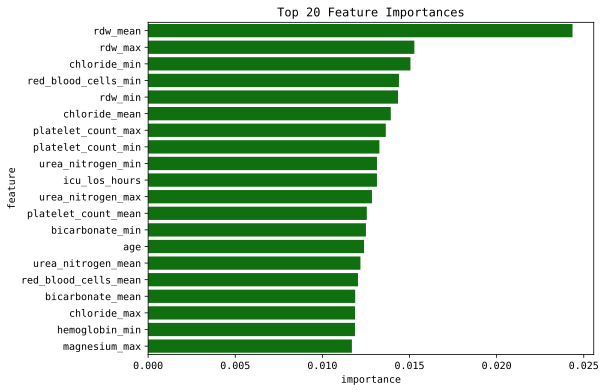

In [9]:
y_pred = final_model.predict(X_test)
y_proba = final_model.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = roc_auc_score(y_test, y_proba)
auprc = average_precision_score(y_test, y_proba)

np.savez(f'../results/xgboost_fpr_tpr_thresholds.npz', fpr, tpr, thresholds)
print("Classification Report:\n", classification_report(y_test, y_pred))
print(f"ROC-AUC: {roc_auc:.4f}")
_, lower, upper = bootstrap_auc_ci(y_test, y_proba)
print(f"95% CI = [{lower:.4f}, {upper:.4f}]")

importances = final_model.feature_importances_
feat_imp = pd.DataFrame({'feature': X.columns, 'importance': importances})
feat_imp = feat_imp.sort_values('importance', ascending=False).head(20)

plt.figure(figsize=(8,6))
sns.barplot(y='feature', x='importance', data=feat_imp, color='green')
plt.title("Top 20 Feature Importances")
plt.show()